# Classification with South Park Dialogue

Taylor Willingham<br>
September 2019
<img src="images/sp_logo.png" alt="South Park sign" width=150>

### Introduction

This project combines Natural Language Processing and classification to predict characters given a line of dialogue. The main steps were to create the word corpus and preprocess the text -- including remove punctuation, expand contractions, lemmatize the words -- convert the lines of dialogue to vectors with CountVectorizer of TfidfVectorizer, and, finally, use those vectors to train various models in an attempt to find the best one. Unfortunately, regardless of the algorithm used, none of the results were up to the level I had hoped to achieve. Using a version of Support Vector Machines, I obtained an accuracy of just under 43%, well below what I might consider successful. In the conclusion I give some thoughts as to why this might be, and where to go next.

<b>Layout</b><br>
This notebook consists of the following sections:
* <b>Overview</b>
* <b>Exploring the Data</b>
* <b>Modeling</b>
* <b>Conclusions</b>
<img src="images/sp_boys_waving.png" alt="South Park boys waving" width=300>

## Overview

The general intent for this project is to dive into the methods and techniques of natural language processing to get some experience using machine learning on textual data. In order to do so, I have chosen a data set of scripts broken down line by line from episodes of the television show South Park. With this data, my aim is to train a model that, when given a line of dialogue, will be able to accurately predict which character is speaking.<br>
<br>
Now, let’s be clear: this is more of a fun passion project versus anything substantial. Knowing which South Park character is speaking probably isn’t very important, and if you’re hearing the line for the first time you can probably already see who is delivering the line. However, the techniques used here have infinite potential applications. It boils down to a classification problem, where labels are predicted based on text. This could be used to sort types of documents, categorize articles by subject, seek out examples of plagiarism, and countless other things. Not to equate South Park with Shakespeare, but it’s not all that different from scholars trying to determine whether or not an anonymous piece of literature is from the hand of the great poet and playwright. So, even though this project focuses on a comedy TV show, the potential implications reach much further.

## Exploring the Data

<b>Section Overview</b><br>
This section covers loading the data, truncating the data set, establishing the word corpus, selecting stop words and using word clouds and other visuals to help get an overview of the textual content.

<b>Load in some basic packages</b><br>
First things first

In [3]:
# Load in the packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
%matplotlib inline
sns.set_style('darkgrid')

<b>Load in the data set</b><br>
Import the data and do some basic cleaning. Detailed explanations can be found in report 1, located in the repository subfolder <a href="https://github.com/twillstw/NLP-with-South-Park/tree/master/reports">here</a>.

In [4]:
lines = pd.read_csv('./data/All-seasons.csv')

# Remove unnecessary data
lines = lines[lines.Season != 'Season']

# Convert some features to the correct data type
lines[['Season', 'Episode']] = lines[['Season', 'Episode']].astype('int64')

With the basic data set loaded and prepped, we can check the shape the first few rows.

In [5]:
lines.shape

(70879, 4)

In [6]:
lines.head(3)

,Season,Episode,Character,Line
0,10,1,Stan,"You guys, you guys! Chef is going away. \n"
1,10,1,Kyle,Going away? For how long?\n
2,10,1,Stan,Forever.\n


As we can see, there are roughly 71,000 lines of dialogue, or documents for the purpose of this project, and only one real feature of importance, which is `Line`. The `Character` column represents the target label.<br>
<br>
For a macro level overview, here is the distribution of lines across seasons:

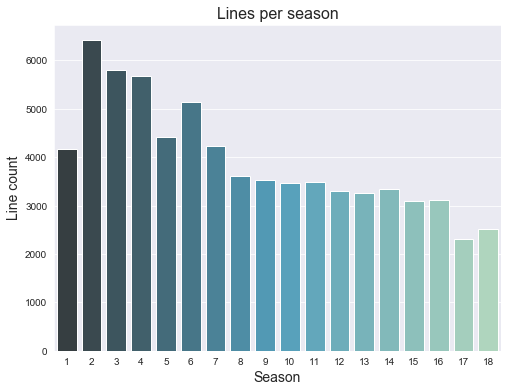

In [7]:
lines_per_season = lines.groupby('Season').count()[['Line']].sort_index()

fig = plt.subplots(figsize=(8,6))
_ = sns.barplot(lines_per_season.index, lines_per_season.Line, palette='GnBu_d')
_ = plt.xlabel('Season', fontsize=14)
_ = plt.ylabel('Line count', fontsize=14)
_ = plt.title('Lines per season', fontsize=16)

Clearly there are more lines in the first few seasons, the main reason likely being that later seasons have fewer episodes. It's not clear if this really matters, but if there are general overarching changes in the show vocabulary as a whole then that means that the data may be biased towards the earlier seasons. That might be difficult to quantify, but it could have a subtle effect on the results.

<b>Character distribution</b><br>
The next important thing to examine is the number of characters represented in the data, or how many classes we are dealing with, and also how many lines of dialogue are associated with each character. I used a `Counter` object for these tasks.

In [8]:
from collections import Counter

character_count = Counter(lines.Character)
len(character_count)

3949

In [9]:
character_count.most_common(15)

[('Cartman', 9774),
 ('Stan', 7680),
 ('Kyle', 7099),
 ('Butters', 2602),
 ('Randy', 2467),
 ('Mr. Garrison', 1002),
 ('Chef', 917),
 ('Kenny', 881),
 ('Sharon', 862),
 ('Mr. Mackey', 633),
 ('Gerald', 626),
 ('Jimmy', 597),
 ('Wendy', 585),
 ('Liane', 582),
 ('Sheila', 566)]

To visualize these distributions we can generate a bar plot:

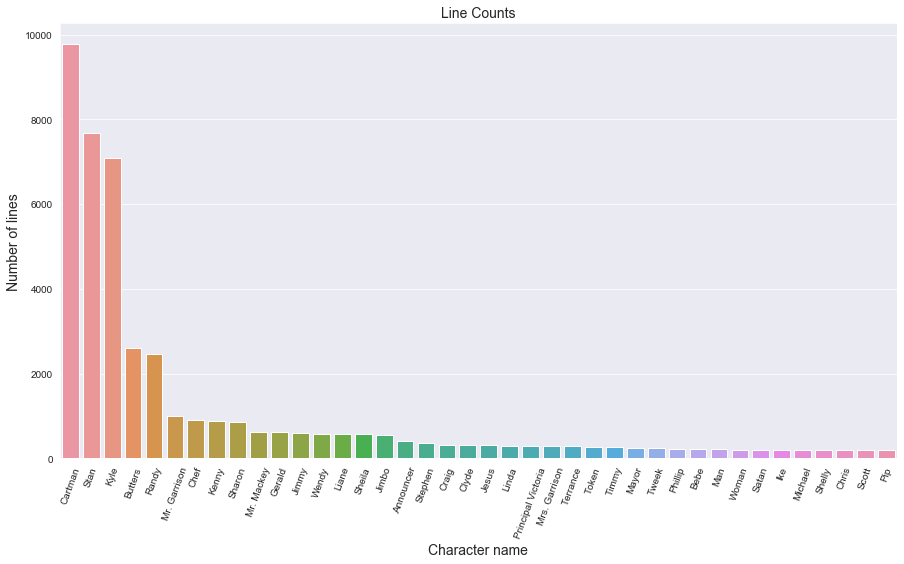

In [10]:
names = [tup[0] for tup in character_count.most_common(40)]
counts = [tup[1] for tup in character_count.most_common(40)]

fig = plt.subplots(figsize=(15,8))
_ = sns.barplot(names, counts)
_ = plt.xlabel('Character name', fontsize=14)
_ = plt.ylabel('Number of lines', fontsize=14)
_ = plt.title('Line Counts', fontsize=14)
_ = plt.xticks(rotation=70)

In total, there are nearly 4,000 (!!) characters. This makes sense given that South Park, like any show, has many temporary and minor characters. However, this is way too many labels to deal with, so a decision needs to be made. We can either focus on particular characters and disregard the rest, or we group characters based on certain criteria, like primary versus secondary characters, and make it a binary classification problem.<br>
<br>
I chose the first approach, as that is more in line with the original intent from the outset. Judging by the counts and the visualization, the first five characters clearly stand out and represent a sizeable chunk of dialogue, so those are the characters I chose to focus on. Additionally, I wanted to keep some of the supporting dialogue by lumping a few of the more important secondary characters into one group. To keep it homogenous, I chose parents and authority figures for this group. 

In [11]:
support_chars = ['Mr. Garrison', 'Chef', 'Sharon',\
                 'Mr. Mackey', 'Gerald', 'Liane', 'Sheila',\
                 'Stephen', 'Ms. Garrison', 'Mrs. Garrison']

I realize the potential risk of using a group of support characters as a separate label but, again, it's more inline with the original intent. Ideally, I would like to take any line of diaglogue and make a prediction, not just lines from main characters. <br>
<br>
With the decision made, the data set needs to be adjusted and truncated.

In [12]:
lines.loc[lines.Character.isin(support_chars), 'Character'] = 'Support Character'

final_labels = ['Cartman', 'Stan', 'Kyle', 'Butters', 'Randy', 'Support Character']

lines_final = lines[lines.Character.isin(final_labels)]

### Word Corpus and Vocab Preprocesing

Now that we have extracted the data of interest, it needs to be preprocessed to get it into a format more suitable for machine learning. Here is a sample of we're starting with:

In [14]:
lines_final.iloc[4:9]

,Season,Episode,Character,Line
4,10,1,Stan,"Chef said he's been bored, so he joining a gro..."
5,10,1,Support Character,Wow!\n
6,10,1,Support Character,Chef?? What kind of questions do you think adv...
7,10,1,Support Character,What's the meaning of life? Why are we here?\n
8,10,1,Support Character,I hope you're making the right choice.\n


And here are the general steps I followed in order to get to the final word corpus:
* Compile all strings, or lines of dialogue into one list
* Remove the new-line figure (`\n`) from each line
* Convert each word to lowercase and remove punctuation
* Expand all contractions to their whole words
* Lemmatize all nouns and verbs so that only root words are present  
<br>
<br>
For more insight, refer to Notebook 2 in the <a href="https://github.com/twillstw/NLP-with-South-Park/tree/master/reports">reports</a> subfolder.

In [15]:
import re, string
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
import contractions

corpus = lines_final.Line.tolist()

for line in range(len(corpus)):
    corpus[line] = re.sub('\\n', '', corpus[line].rstrip()).lower()
    corpus[line] = " ".join(word.strip(string.punctuation) for word in corpus[line].split())
    
corpus[4:9]

["chef said he's been bored so he joining a group called the super adventure club",
 'wow',
 'chef what kind of questions do you think adventuring around the world is gonna answer',
 "what's the meaning of life why are we here",
 "i hope you're making the right choice"]

Above, we can see that the new-line figure is removed, all letters are lowercase and the punctuation is removed. Next, contractions are expanded.

In [16]:
for line in range(len(corpus)):
    corpus[line] = contractions.fix(corpus[line])
                                  
corpus[4:9]

['chef said he is been bored so he joining a group called the super adventure club',
 'wow',
 'chef what kind of questions do you think adventuring around the world is going to answer',
 'what is the meaning of life why are we here',
 'i hope you are making the right choice']

And finally, the words are lemmatized.

In [17]:
lem = WordNetLemmatizer()

def lemmatize_lines(line):
    '''function to lemmatize the corpus
    line by line'''
    word_list = word_tokenize(line)
    
    word_list = [lem.lemmatize(w, pos='v') for w in word_list]
    
    lem_line = ' '.join([lem.lemmatize(w) for w in word_list])
    
    return lem_line

In [18]:
for line in range(len(corpus)):
    corpus[line] = lemmatize_lines(corpus[line])
    
corpus[4:9]

['chef say he be be bore so he join a group call the super adventure club',
 'wow',
 'chef what kind of question do you think adventure around the world be go to answer',
 'what be the mean of life why be we here',
 'i hope you be make the right choice']

<img src="images/chef.png" alt="Chef waving" width=140>

### Word Frequencies and Stop Words

With the corpus cleaned, we can now calculate which words occur most frequently and search for potential stop words. To do this, I used a `Counter` and an `OrderedDict` to order words by their total frequencies. I then created two functions to compare the words individually to confirm whether or not they should be treated as stop words. In essence, words that are not evenly distributed across all classes but tend to distinguish one or two classes from the others have more significance and should not be treated as stop words. This is similar to the concept of tf-idf, which is implemented later. 

In [21]:
words = " ".join(corpus)

from collections import Counter, OrderedDict

word_counts = Counter(words.split())

token_dict = OrderedDict(word_counts.most_common())

# An abridged list of the most common words
[(k, v) for k, v in token_dict.items()][:10]

[('be', 25112),
 ('you', 14922),
 ('to', 12042),
 ('the', 10594),
 ('i', 9894),
 ('do', 8119),
 ('not', 7950),
 ('it', 7724),
 ('a', 7723),
 ('we', 6360)]

In [22]:
def freq_compare(word, corpus=corpus):
    '''Takes a word and a word corpus and calculates
    the total word frequency and the number of documents
    containing that word.'''
    
    word = word.lower()
    
    words = " ".join(corpus).lower()
    words = " ".join(word.strip(string.punctuation) for word in words.split())
    
    word_counts = Counter(words.split())
    token_dict = OrderedDict(word_counts.most_common())
    
    total_frequency = token_dict[word]
    
    doc_freq = 0
    
    for line in corpus:
        if word in [token.strip(string.punctuation).lower() for token in line.split()]:
            doc_freq += 1
    
    print('The total frequency of the word \'{}\' is: \t'.format(word), total_frequency)
    print('The number of documents with the word \'{}\': \t'.format(word), doc_freq)
    
def compare_labels(term):
    '''Takes a particular word and calculates
    how often it is used by each character'''
    
    term = term.lower()
    
    count_dict = {'Cartman': 0, 'Stan': 0, 'Kyle': 0, 'Butters': 0,\
                  'Randy': 0, 'Support Character': 0}
    
    for k, v in count_dict.items():
        subset = lines_final[lines_final.Character == k]
        
        corpus = subset.Line.tolist()

        for line in range(len(corpus)):
            corpus[line] = re.sub('\\n', '', corpus[line].rstrip())
        
        words = " ".join(corpus).lower()
        words = " ".join(word.strip(string.punctuation) for word in words.split())
    
        word_counts = Counter(words.split())
        token_dict = OrderedDict(word_counts.most_common())
        
        if term in token_dict.keys():
            count_dict[k] += token_dict[term]
        
        # Now convert to a ratio
        count_dict[k] = round((count_dict[k] / len(subset)), 3)
    
    print('How often the word \'{}\' appears in each class:'.format(term))
    print(count_dict)

In [23]:
def word_freqs(word):
    freq_compare(word)
    compare_labels(word)

word_freqs('do')

The total frequency of the word 'do' is: 	 8119
The number of documents with the word 'do': 	 6787
How often the word 'do' appears in each class:
{'Cartman': 0.075, 'Stan': 0.075, 'Kyle': 0.076, 'Butters': 0.087, 'Randy': 0.086, 'Support Character': 0.078}


Using the functions and the example word 'do', we can see that the word occurs frequently and is used similarly by all characters. This means it is not very unique and does not convey much information, so it can be treated as a stop word. After comparing several of the most frequent terms, this is list of stop words that I compiled.

In [24]:
sw = ['be', 'you', 'i', 'to', 'the', 'do', 'it',\
        'a', 'we', 'that', 'and', 'have', 'go', 'what',\
        'get', 'of', 'this', 'in', 'on', 'all', 'just',\
        'for', 'he', 'know', 'will', 'but', 'with', 'so',\
        'they', 'now', 'well', "'s", 'guy', 'u', 'come',\
        'like', 'there', 'at', 'would', 'who', 'him',\
        'them', 'his', 'thing', 'where', 'should', 'an',\
        'please', 'maybe', 'their', 'even', 'any', 'than']

### Word Clouds

Beyond simple line counts, word clouds are a useful way to visualize word frequencies. This can be helpful to see how certain characters might favor certain words, illustrating differences in dialogue. See notebook 3 in the reports subfolder for more examples, but below is a function to create character-specific word clouds along with a few examples.

In [30]:
from wordcloud import WordCloud
font_path = './data/CabinCondensed-Medium.ttf'

def character_cloud(character):
    
    subset = lines_final[lines_final.Character == character]
    
    sub_corp = subset.Line.tolist()
    for line in range(len(sub_corp)):
        sub_corp[line] = re.sub('\\n', '', sub_corp[line].rstrip())
        sub_corp[line] = sub_corp[line].lower()
        sub_corp[line] = " ".join(word.strip(string.punctuation) for word in sub_corp[line].split())
        sub_corp[line] = contractions.fix(sub_corp[line])
        sub_corp[line] = lemmatize_lines(sub_corp[line])
        
    char_cloud = WordCloud(stopwords=sw,\
                           font_path=font_path,\
                           random_state=2,\
                           normalize_plurals=False,\
                           background_color='#ddf2eb').generate(str(sub_corp))
    
    fig = plt.subplots(figsize=(8,6))
    _ = plt.imshow(char_cloud, interpolation='bilinear')
    _ = plt.axis('off')
    _ = plt.title(character, fontsize=26)

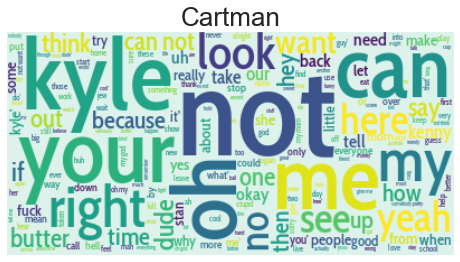

In [32]:
character_cloud('Cartman')

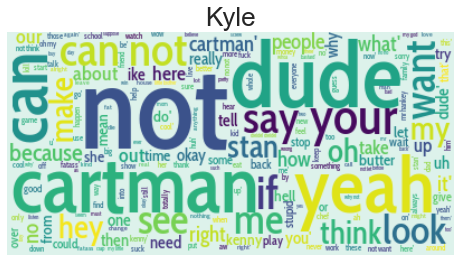

In [33]:
character_cloud('Kyle')

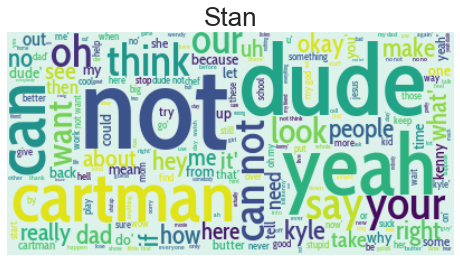

In [34]:
character_cloud('Stan')

The similarity between the word clouds for Stan and Kyle is striking, while Cartman seems to really favor 'me' and 'my' comparative to the others.

## Modeling

So the word corpus has been prepared, and now it's time to try and find the model that makes the most accurate prediction. Before a model can be trained though, the word corpus needs to be converted into mathematical vectors. To achieve this, I used `CountVectorizer` and `TfidfVectorizer` from Scikit Learn. Once the vectorized dictionary was established, I split the data into test and training sets in order to train a model. With each of the different vector types I first started with a Multinomial Naive Bayes algorithm. From there, I also used the tf-idf vector to train other models using Random Forest, SVM and Logistic Regression. Unfortunately, the results did not improve by much.

<b>Establishing the CountVectorizer</b><br>
This is essentially a bag of words, where documents are assessed based on how many times each word appears. Also of note is the `ngram_range` parameter, which accounts for unigrams, bigrams and so on. I tested for several ranges, but larger values of n-gram only added more features without improving performance. See notebook 4 in the reports subfolder for more details.

In [35]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

In [36]:
vectorizer = CountVectorizer(stop_words=sw, ngram_range=(1,1))

X = vectorizer.fit_transform(corpus)
y = lines_final.Character

state = 3

# How many features are there?
X.shape[1]

12333

<b>Splitting the data and training Multinomial Naive Bayes</b><br>
Now the features, X, and the target labels, y, need to be split into test and training sets. Then we can fit the data to a Multinomial Naive Bayes model and cross validate on the training data before checking against the test data.

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=state)

In [38]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

mnb = MultinomialNB()

cv_scores = cross_val_score(mnb, X_train, y_train, cv=5)

In [39]:
print('Scores: ', cv_scores)
print('Average score: ', np.mean(cv_scores))

Scores:  [0.40567747 0.41510574 0.40407094 0.41031842 0.4069744 ]
Average score:  0.4084293941887636


Clearly not a great result.<br>
<br>
Experimenting further with hyper-tuning values of *alpha* for `MultinomialNB` only yields a slight improvement.

In [40]:
from sklearn.model_selection import GridSearchCV

params = {'alpha': [0.1, 0.2, 0.3, 0.5, 0.75, 0.9, 1.0]}

nb_grid = GridSearchCV(mnb, params, cv=5)

nb_grid.fit(X_train, y_train)

print('Best alpha: ', nb_grid.best_estimator_)
print('Best score: ', nb_grid.best_score_)

Best alpha:  MultinomialNB(alpha=0.5, class_prior=None, fit_prior=True)
Best score:  0.4144336543498408


Now to check it against the test data:

In [42]:
pred = nb_grid.predict(X_test)
print(accuracy_score(y_test, pred))

0.42239353201090535


### Tf-idf

To try and make further improvements, we can use a weighted tf-idf vectorizer instead of a basic CountVectorizer. Stop words aren't as big of a concern here due to the inherent adjustments, but since we already have a list we may as well use it. Also, because this is a new vectorizer we will have to create new train and test splits.

In [43]:
from sklearn.feature_extraction.text import TfidfVectorizer

tf_vect = TfidfVectorizer(stop_words=sw)

X = tf_vect.fit_transform(corpus)
y = lines_final.Character

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=state)

Now to run the new splits with MultinomialNB and check the scores.

In [44]:
nb_grid.fit(X_train, y_train)

print('Best alpha: ', nb_grid.best_estimator_)
print('Best score: ', nb_grid.best_score_)

Best alpha:  MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True)
Best score:  0.40520610871579965


A different value of *alpha*, but more or less the same result. In fact, it's slightly worse, which is a bit surprising.